In [470]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [471]:
import warnings
warnings.filterwarnings('ignore')

In [472]:
df=pd.read_csv('dataset_full.csv')

In [473]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [474]:
df.describe(include='all')

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.00000,39999.000000,39999.000000,39999.000000,39999.000000,...,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000
mean,2.199130,0.332333,0.114078,1.285032,0.008975,0.21073,0.022651,0.144179,0.002525,0.001125,...,1.137303,2.771319,1.739618,6224.628466,0.508188,0.342559,0.001100,0.001850,0.005125,0.346209
std,1.240181,1.118725,0.626762,1.895881,0.110431,0.97420,0.286603,0.943044,0.069418,0.075326,...,0.898632,1.318320,1.702270,12133.005167,0.499939,0.780921,0.058728,0.063614,0.071407,0.475767
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,2178.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10800.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,23.000000,35.000000,21.000000,44.000000,9.000000,17.00000,43.000000,26.000000,8.000000,9.000000,...,24.000000,16.000000,20.000000,604800.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000


In [475]:
# List of useful columns
useful_columns = [
    "length_url", "qty_dot_url", "qty_hyphen_url", "qty_slash_url",
    "qty_tld_url", "domain_length", "qty_dot_directory",
    "email_in_url","tls_ssl_certificate", "phishing"
]
# Drop other columns from the DataFrame
df = df[useful_columns]

In [476]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of length_url is : 20.772230127975867
The skewness of qty_dot_url is : 5.386235951038229
The skewness of qty_hyphen_url is : 7.752313313630377
The skewness of qty_slash_url is : 2.1730076312134305
The skewness of qty_tld_url is : 6.814538924686532
The skewness of domain_length is : 3.947493815902789
The skewness of qty_dot_directory is : 2.206840064394652
The skewness of email_in_url is : 7.071194860418037
The skewness of tls_ssl_certificate is : -0.03275643919582868
The skewness of phishing is : 0.6465314165217684


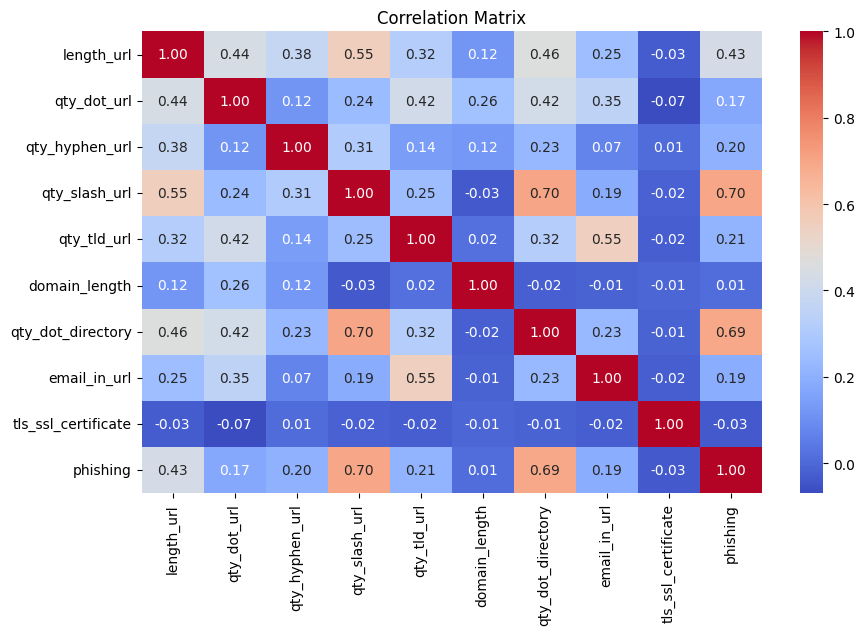

In [477]:
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [478]:
def impute_outliers(data, column):
    Q1 = data[column].quantile(0.10)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = data[column].mean()
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])
    return data

columns_to_check = ['email_in_url','qty_tld_url','qty_hyphen_url']
data=df.copy()
for column in columns_to_check:
    data = impute_outliers(data, column)

df=data

In [479]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of length_url is : 20.772230127975867
The skewness of qty_dot_url is : 5.386235951038229
The skewness of qty_hyphen_url is : 2.5232761422984207
The skewness of qty_slash_url is : 2.1730076312134305
The skewness of qty_tld_url is : 4.245732512945193
The skewness of domain_length is : 3.947493815902789
The skewness of qty_dot_directory is : 2.206840064394652
The skewness of email_in_url is : 7.071194860418036
The skewness of tls_ssl_certificate is : -0.03275643919582868
The skewness of phishing is : 0.6465314165217684


In [480]:
df["email_in_url"] = np.log1p(df["email_in_url"])
df["qty_tilde_url"] = np.log1p(df["qty_tld_url"])

In [481]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of length_url is : 20.772230127975867
The skewness of qty_dot_url is : 5.386235951038229
The skewness of qty_hyphen_url is : 2.5232761422984207
The skewness of qty_slash_url is : 2.1730076312134305
The skewness of qty_tld_url is : 4.245732512945193
The skewness of domain_length is : 3.947493815902789
The skewness of qty_dot_directory is : 2.206840064394652
The skewness of email_in_url is : 7.071194860418033
The skewness of tls_ssl_certificate is : -0.03275643919582868
The skewness of phishing is : 0.6465314165217684
The skewness of qty_tilde_url is : 4.245732512945261


In [482]:
df.head()

,length_url,qty_dot_url,qty_hyphen_url,qty_slash_url,qty_tld_url,domain_length,qty_dot_directory,email_in_url,tls_ssl_certificate,phishing,qty_tilde_url
0,25,3,0.0,1,1.000000,17,1,0.0,0,1,0.693147
1,223,5,0.0,3,1.048301,16,3,0.0,1,1,0.717011
2,15,2,0.0,1,1.000000,14,0,0.0,1,0,0.693147
3,81,4,0.0,5,1.000000,19,2,0.0,1,1,0.693147
4,19,2,0.0,0,1.000000,19,-1,0.0,0,0,0.693147


In [483]:
x=df.drop(['phishing'],axis=1).values
y=df['phishing'].values

In [484]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [485]:
RF=RandomForestClassifier(n_estimators=100,random_state=42)
RF_Model=RF.fit(x_train,y_train)

In [486]:
y_pred=RF.predict(x_test)

In [487]:
x.shape

(39999, 10)

In [488]:
y.shape

(39999,)

In [489]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5296
           1       0.90      0.87      0.88      2704

    accuracy                           0.92      8000
   macro avg       0.92      0.91      0.91      8000
weighted avg       0.92      0.92      0.92      8000



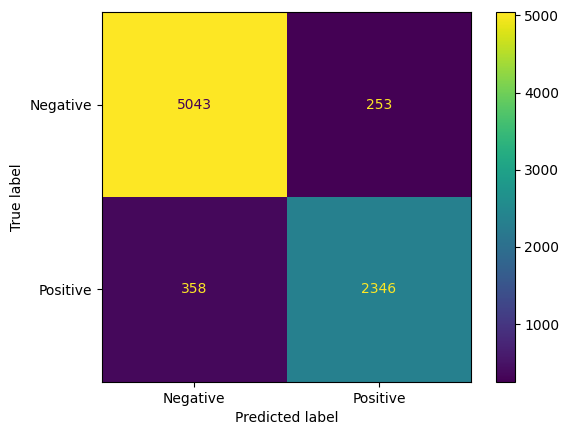

In [490]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()